In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from sklearn.decomposition import MiniBatchNMF

import pickle
import matplotlib.pyplot as plt

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex

2023-04-16 09:27:37.728077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 09:27:38.590516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
metadata = pd.read_csv('train.csv')
len(metadata.image_id.unique())

54706

In [4]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


# Pre-train NMF on each fold's training split

Using the best hyperparameters from the search using scikit-learn HalvingRandomGridSearch with NMF + logistic regression (default hyperparameters) pipeline, optimizing for average precision score.

**Image resolution:** 512 x 512

**Best hyperparameters**
- n_components = 26
- init = 'random'
- beta_loss = 'kullback-leibler' 
- alpha_W (= alpha_H) = 0.9
- l1_ratio = 0.3

In [5]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [6]:
for i in range(5):
    print(len(cv_img[i]['train']))

28031
28016
27937
28025
28003


In [8]:
N_COMPONENTS = 26

BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)
#BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/shared_data/team_mammogram/train_images' # directory of all images
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models
RANDOM_STATE = 42

train_time_512 = fex.cv_train_feature_extractor(
    cv_img = cv_img,
    patient_img_dict = splitter.trainset,
    batch_size = BATCH_SIZE,
    basepath = BASEPATH,
    img_size = IMG_SIZE,
    normalize = (0, 1),
    
    from_numpy = True,
    random_state = RANDOM_STATE,
    
    model_name = 'NMF',
    n_components = N_COMPONENTS,
    init = 'random',
    beta_loss= 'kullback-leibler',
    alpha_W = 0.9,
    l1_ratio = 0.3,
    
    extractor_path = EXTRACTOR_PATH,
    verbose = True,
    evaluate = False,
    return_none = True   
)

Fold:  0
Initialized NMF with n_components = 26
--Training batch  1
--Training batch  2
--Training batch  3
--Training batch  4
--Training batch  5
--Training batch  6
--Training batch  7
--Training batch  8
--Training batch  9
--Training batch  10
--Training batch  11
--Training batch  12
--Training batch  13
--Training batch  14
--Training batch  15
--Training batch  16
--Training batch  17
--Training batch  18
--Training batch  19
--Training batch  20
--Training batch  21
--Training batch  22
--Training batch  23
--Training batch  24
--Training batch  25
--Training batch  26
--Training batch  27
--Training batch  28
--Training batch  29
--Training batch  30
--Training batch  31
--Training batch  32
--Training batch  33
--Training batch  34
--Training batch  35
--Training batch  36
--Training batch  37
--Training batch  38
--Training batch  39
--Training batch  40
--Training batch  41
--Training batch  42
--Training batch  43
--Training batch  44
--Training batch  45
--Training batch

# Calculating explained variance and reconstruction error

Based on the same training set that the model was trained on so that the explained variance would be comparable to the values obtained by PCA.

In [9]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays

nmf_0 = pickle.load(open('models/NMF_26_42_512_0.pkl', 'rb'))

img_gen = dl.ImgGenerator(
                list_IDs = cv_img[0]['train'],
                patient_img_dict = splitter.trainset,
                batch_size = BATCH_SIZE,
                basepath = BASEPATH,
                img_size = IMG_SIZE,
                normalize = (0, 1),
                from_numpy = True
            )

fold_0 = fex.evaluate_feature_extractor(img_gen, nmf_0)

Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
--Transforming batch  5
---Reconstructing batch
--Transforming batch  6
---Reconstructing batch
--Transforming batch  7
---Reconstructing batch
--Transforming batch  8
---Reconstructing batch
--Transforming batch  9
---Reconstructing batch
--Transforming batch  10
---Reconstructing batch
--Transforming batch  11
---Reconstructing batch
--Transforming batch  12
---Reconstructing batch
--Transforming batch  13
---Reconstructing batch
--Transforming batch  14
---Reconstructing batch
--Transforming batch  15
---Reconstructing batch
--Transforming batch  16
---Reconstructing batch
--Transforming batch  17
---Reconstructing batch
--Transforming batch  18
---Reconstructing batch
--Transforming batch  19
---Reconstructing batch
--Transforming batch  20
---Reconstructing batch
--Transfo

In [10]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays

nmf_1 = pickle.load(open('models/NMF_26_42_512_1.pkl', 'rb'))

img_gen = dl.ImgGenerator(
                list_IDs = cv_img[1]['train'],
                patient_img_dict = splitter.trainset,
                batch_size = BATCH_SIZE,
                basepath = BASEPATH,
                img_size = IMG_SIZE,
                normalize = (0, 1),
                from_numpy = True
            )

fold_1 = fex.evaluate_feature_extractor(img_gen, nmf_1)

Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
--Transforming batch  5
---Reconstructing batch
--Transforming batch  6
---Reconstructing batch
--Transforming batch  7
---Reconstructing batch
--Transforming batch  8
---Reconstructing batch
--Transforming batch  9
---Reconstructing batch
--Transforming batch  10
---Reconstructing batch
--Transforming batch  11
---Reconstructing batch
--Transforming batch  12
---Reconstructing batch
--Transforming batch  13
---Reconstructing batch
--Transforming batch  14
---Reconstructing batch
--Transforming batch  15
---Reconstructing batch
--Transforming batch  16
---Reconstructing batch
--Transforming batch  17
---Reconstructing batch
--Transforming batch  18
---Reconstructing batch
--Transforming batch  19
---Reconstructing batch
--Transforming batch  20
---Reconstructing batch
--Transfo

In [11]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays

nmf_2 = pickle.load(open('models/NMF_26_42_512_2.pkl', 'rb'))

img_gen = dl.ImgGenerator(
                list_IDs = cv_img[2]['train'],
                patient_img_dict = splitter.trainset,
                batch_size = BATCH_SIZE,
                basepath = BASEPATH,
                img_size = IMG_SIZE,
                normalize = (0, 1),
                from_numpy = True
            )

fold_2 = fex.evaluate_feature_extractor(img_gen, nmf_2)

Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
--Transforming batch  5
---Reconstructing batch
--Transforming batch  6
---Reconstructing batch
--Transforming batch  7
---Reconstructing batch
--Transforming batch  8
---Reconstructing batch
--Transforming batch  9
---Reconstructing batch
--Transforming batch  10
---Reconstructing batch
--Transforming batch  11
---Reconstructing batch
--Transforming batch  12
---Reconstructing batch
--Transforming batch  13
---Reconstructing batch
--Transforming batch  14
---Reconstructing batch
--Transforming batch  15
---Reconstructing batch
--Transforming batch  16
---Reconstructing batch
--Transforming batch  17
---Reconstructing batch
--Transforming batch  18
---Reconstructing batch
--Transforming batch  19
---Reconstructing batch
--Transforming batch  20
---Reconstructing batch
--Transfo

In [6]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays

nmf_3 = pickle.load(open('models/NMF_26_42_512_3.pkl', 'rb'))

img_gen = dl.ImgGenerator(
                list_IDs = cv_img[3]['train'],
                patient_img_dict = splitter.trainset,
                batch_size = BATCH_SIZE,
                basepath = BASEPATH,
                img_size = IMG_SIZE,
                normalize = (0, 1),
                from_numpy = True
            )

fold_3 = fex.evaluate_feature_extractor(img_gen, nmf_3)

Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
--Transforming batch  5
---Reconstructing batch
--Transforming batch  6
---Reconstructing batch
--Transforming batch  7
---Reconstructing batch
--Transforming batch  8
---Reconstructing batch
--Transforming batch  9
---Reconstructing batch
--Transforming batch  10
---Reconstructing batch
--Transforming batch  11
---Reconstructing batch
--Transforming batch  12
---Reconstructing batch
--Transforming batch  13
---Reconstructing batch
--Transforming batch  14
---Reconstructing batch
--Transforming batch  15
---Reconstructing batch
--Transforming batch  16
---Reconstructing batch
--Transforming batch  17
---Reconstructing batch
--Transforming batch  18
---Reconstructing batch
--Transforming batch  19
---Reconstructing batch
--Transforming batch  20
---Reconstructing batch
--Transfo

In [7]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)
BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays

nmf_4 = pickle.load(open('models/NMF_26_42_512_4.pkl', 'rb'))

img_gen = dl.ImgGenerator(
                list_IDs = cv_img[4]['train'],
                patient_img_dict = splitter.trainset,
                batch_size = BATCH_SIZE,
                basepath = BASEPATH,
                img_size = IMG_SIZE,
                normalize = (0, 1),
                from_numpy = True
            )

fold_4 = fex.evaluate_feature_extractor(img_gen, nmf_4)

Start evaluation...
--Transforming batch  1
---Reconstructing batch
--Transforming batch  2
---Reconstructing batch
--Transforming batch  3
---Reconstructing batch
--Transforming batch  4
---Reconstructing batch
--Transforming batch  5
---Reconstructing batch
--Transforming batch  6
---Reconstructing batch
--Transforming batch  7
---Reconstructing batch
--Transforming batch  8
---Reconstructing batch
--Transforming batch  9
---Reconstructing batch
--Transforming batch  10
---Reconstructing batch
--Transforming batch  11
---Reconstructing batch
--Transforming batch  12
---Reconstructing batch
--Transforming batch  13
---Reconstructing batch
--Transforming batch  14
---Reconstructing batch
--Transforming batch  15
---Reconstructing batch
--Transforming batch  16
---Reconstructing batch
--Transforming batch  17
---Reconstructing batch
--Transforming batch  18
---Reconstructing batch
--Transforming batch  19
---Reconstructing batch
--Transforming batch  20
---Reconstructing batch
--Transfo

# Visualize the components

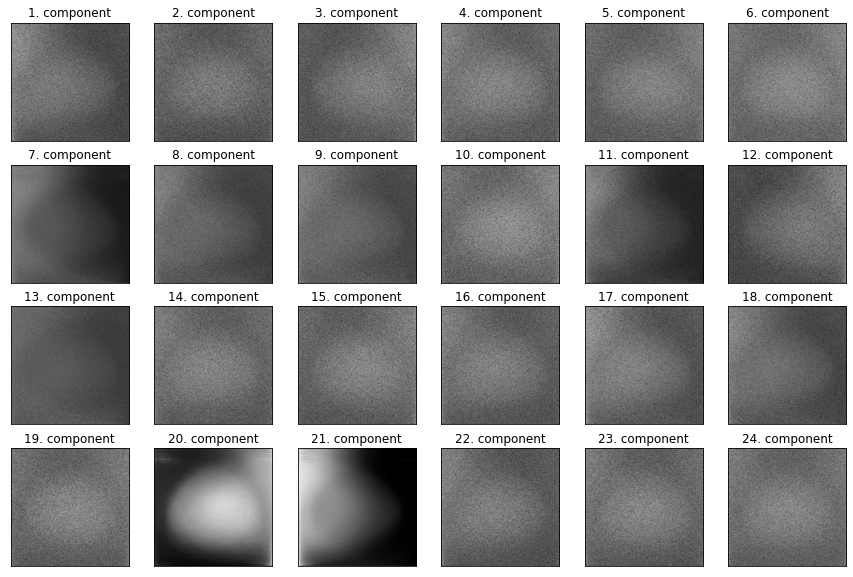

In [17]:
nmf_0 = pickle.load(open('models/NMF_26_42_512_0.pkl', 'rb'))

fig, axes = plt.subplots(4, 6, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf_0.components_[:26], axes.ravel())):
    ax.imshow(component.reshape(512, 512), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

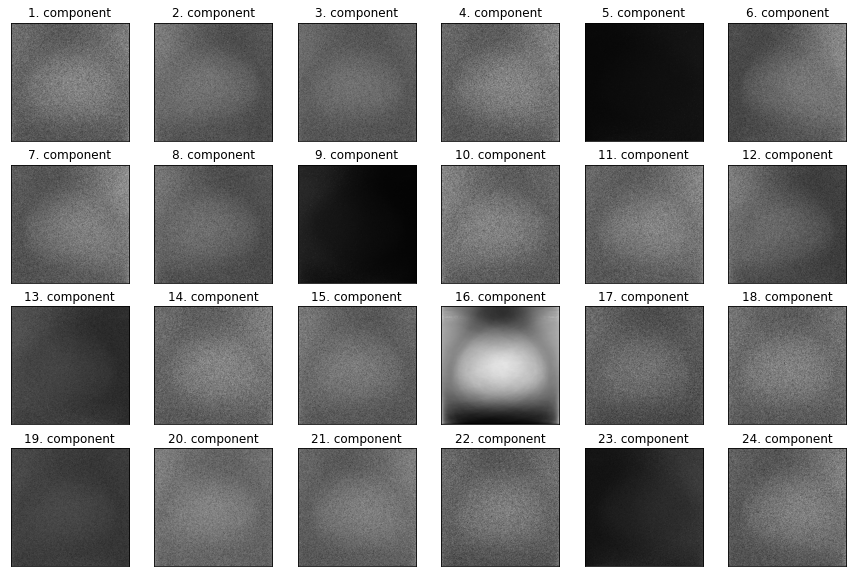

In [19]:
nmf_1 = pickle.load(open('models/NMF_26_42_512_1.pkl', 'rb'))

fig, axes = plt.subplots(4, 6, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf_1.components_[:26], axes.ravel())):
    ax.imshow(component.reshape(512, 512), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

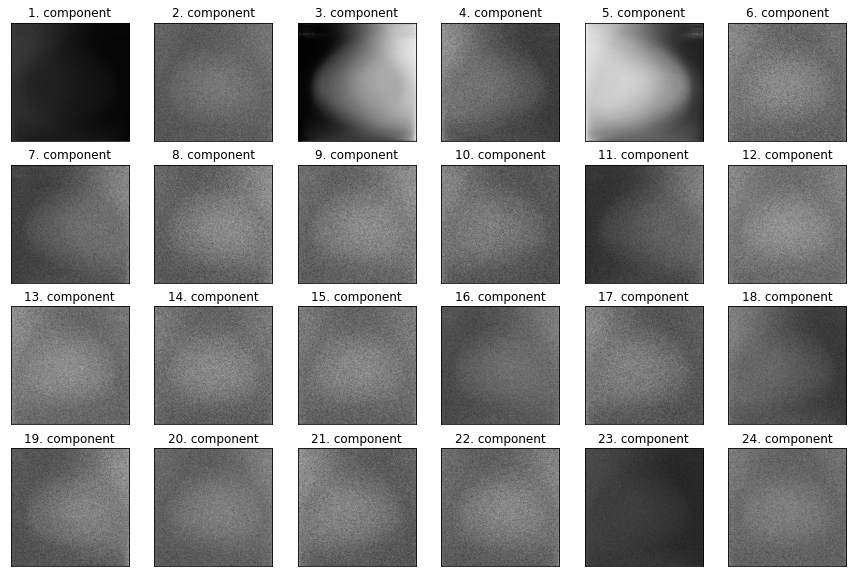

In [20]:
nmf_2 = pickle.load(open('models/NMF_26_42_512_2.pkl', 'rb'))

fig, axes = plt.subplots(4, 6, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf_2.components_[:26], axes.ravel())):
    ax.imshow(component.reshape(512, 512), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

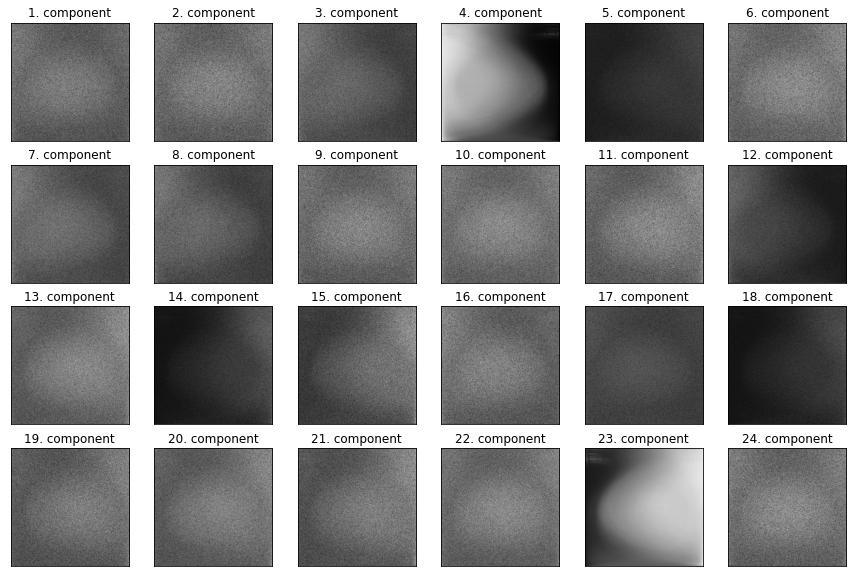

In [21]:
nmf_3 = pickle.load(open('models/NMF_26_42_512_3.pkl', 'rb'))

fig, axes = plt.subplots(4, 6, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf_3.components_[:26], axes.ravel())):
    ax.imshow(component.reshape(512, 512), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

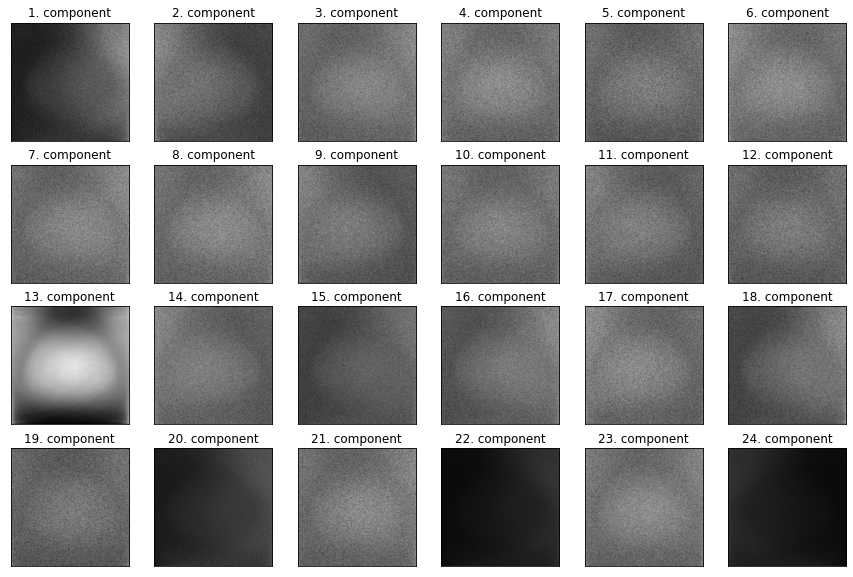

In [22]:
nmf_4 = pickle.load(open('models/NMF_26_42_512_4.pkl', 'rb'))

fig, axes = plt.subplots(4, 6, figsize=(15, 10), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf_4.components_[:26], axes.ravel())):
    ax.imshow(component.reshape(512, 512), cmap='gray')
    ax.set_title("{}. component".format((i + 1)))